In [1]:
# import osmnx as ox 
# from simulation_graph import SimulationGraph


# filters = '["highway"~"motorway"]'

# graph = SimulationGraph.from_osmnx("Polska")

# ox.plot_graph(graph)

In [2]:
# print(len(list(graph.nodes())))
# len(list(graph.edges()))


# graph.remove_edges_attribute(["brigde", "ref"])

# for u, v, data in graph.edges(data=True):
#     print(data)

In [3]:
# for node in graph.nodes():
#     print(node)

# graph.nodes[1418295070]

In [4]:
import networkx as nx 
import os
import pickle
from graph_reader import GraphManager
from simulation_graph import SimulationGraph
import osmnx as ox

reader = GraphManager()

graph = reader.load_pickle_graph("poland.pkl")
print(graph.nodes[1418295070])


{'y': 49.9094571, 'x': 22.810219, 'street_count': 3, 'active': True, 'type': 'road'}


C:\Users\renyo\AGH\V_SEM\FlaskProject\.venv\Lib\site-packages\osmnx\_overpass.py:271: UserWarning: This area is 147 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


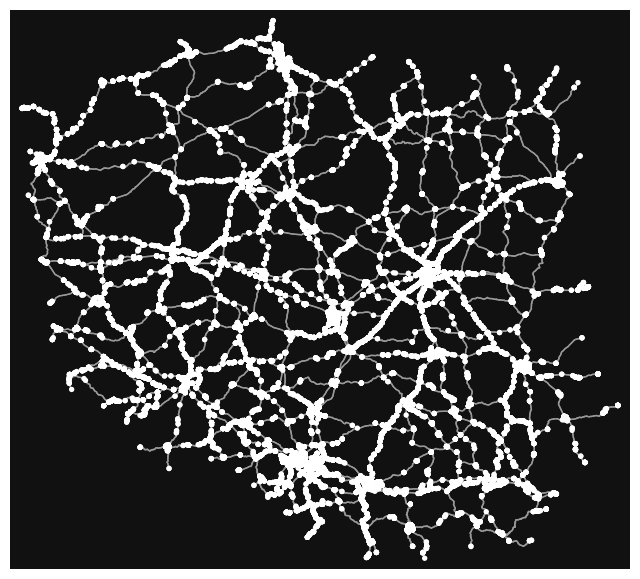

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
import networkx as nx 
import os
import pickle
from graph_reader import GraphManager
from simulation_graph import SimulationGraph
import osmnx as ox

reader = GraphManager()

filters = '["highway"~"motorway|trunk|primary"]'

graph = SimulationGraph.from_osmnx("Polska", custom_filter=filters)


reader.save_pickle_file("poland_motorway_trunk_primary.pkl", graph)
ox.plot_graph(graph)

In [6]:
reader.save_pickle_file("poland_motorway_trunk.pkl", graph)

print(len(graph.nodes()))
print(len(graph.edges()))

23562
34961


In [9]:
import sys, os, math
import networkx as nx
import pandas as pd
from graph_reader import GraphManager
from simulation_graph import SimulationGraph
import models.agents.exporter_agent as exp_mod

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


print("ExporterAgent module file:", exp_mod.__file__)
print("ExporterAgent ma metodę find_cheapest_path:", hasattr(exp_mod.ExporterAgent, "find_cheapest_path"))



reader = GraphManager()
try:
    g_nx = reader.load_pickle_graph("poland.pkl")
    graph = SimulationGraph(
        default_capacity=1000, 
        default_price=1.0, 
        incoming_graph_data=g_nx
    )
    print("✅ Załadowano SimulationGraph z pliku poland.pkl")
except Exception as e:
    print("❌ Błąd wczytywania grafu:", e)
    graph = None



major_cities = {
    "Warszawa": (52.23, 21.01),
    "Kraków": (50.06, 19.94),
    "Łódź": (51.77, 19.46),
    "Wrocław": (51.11, 17.03),
    "Poznań": (52.41, 16.93),
    "Gdańsk": (54.35, 18.65),
    "Szczecin": (53.43, 14.55),
    "Lublin": (51.25, 22.57),
    "Katowice": (50.26, 19.03),
    "Białystok": (53.13, 23.15),
    "Rzeszów": (50.04, 22.00),
    "Olsztyn": (53.78, 20.49),
    "Toruń": (53.01, 18.60),
    "Bydgoszcz": (53.12, 18.01),
    "Kielce": (50.87, 20.63),
    "Zielona Góra": (51.94, 15.50),
    "Opole": (50.67, 17.93),
    "Gorzów Wielkopolski": (52.73, 15.24),
    "Radom": (51.40, 21.15),
    "Częstochowa": (50.81, 19.12),
}

def haversine_km(lat1, lon1, lat2, lon2):
    """Oblicz dystans Haversine między dwoma punktami."""
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    return 6371 * c



exporter_cities = [
    "Warszawa", "Kraków", "Poznań", "Gdańsk", "Wrocław",
    "Szczecin", "Lublin", "Katowice", "Białystok", "Łódź"
]

exporter_nodes = []
for city in exporter_cities:
    lat_c, lon_c = major_cities[city]
    closest_node = min(
        graph.nodes,
        key=lambda n: haversine_km(lat_c, lon_c, graph.nodes[n].get("y", 0), graph.nodes[n].get("x", 0))
    )
    exporter_nodes.append(closest_node)

print(f"✅ Wybrano {len(exporter_nodes)} eksporterów: {exporter_nodes}")



importer_cities = [
    "Rzeszów", "Olsztyn", "Bydgoszcz", "Toruń", "Kielce",
    "Zielona Góra", "Opole", "Gorzów Wielkopolski", "Radom", "Częstochowa"
]

importer_nodes = []
for city in importer_cities:
    lat_c, lon_c = major_cities[city]
    closest_node = min(
        graph.nodes,
        key=lambda n: haversine_km(lat_c, lon_c, graph.nodes[n].get("y", 0), graph.nodes[n].get("x", 0))
    )
    if closest_node not in exporter_nodes:
        importer_nodes.append(closest_node)

print(f"✅ Wybrano {len(importer_nodes)} importerów: {importer_nodes}")



params = {
    "alpha": 1.0,
    "beta": 1.0,
    "gamma": 0.0,
    "avg_speed_km_per_day": 60.0
}

results = []

for i, (exp_node, imp_node) in enumerate(zip(exporter_nodes, importer_nodes), start=1):
    agent = exp_mod.ExporterAgent(agent_id=i, node_id=exp_node)
    try:
        result = agent.find_cheapest_path(graph, dest_node=imp_node, params=params)
        results.append({
            "agent_id": i,
            "exporter_node": exp_node,
            "importer_node": imp_node,
            **result
        })
        print(f"✅ Agent {i}: {exp_node} → {imp_node} | dystans: {result['total_distance_km']:.2f} km | koszt: {result['estimated_cost']:.2f}")
    except Exception as e:
        print(f"❌ {exp_node} → {imp_node} | błąd: {e}")



df_paths = pd.DataFrame(results)
df_paths.to_pickle("../network_data/paths.pkl")
display(df_paths[["exporter_node", "importer_node", "total_distance_km", "estimated_cost", "estimated_lead_time_days", "method"]])

ExporterAgent module file: C:\Users\renyo\AGH\V_SEM\Symulacja Systemów Dyskretnych\Supply_chain_simulator\models\agents\exporter_agent.py
ExporterAgent ma metodę find_cheapest_path: True
✅ Załadowano SimulationGraph z pliku poland.pkl
✅ Wybrano 10 eksporterów: [979061277, 276630136, 301878061, 4249520045, 5165902920, 2175841908, 1599624534, 3184632097, 1908957192, 6330009263]
✅ Wybrano 10 importerów: [2377110618, 3014304872, 1007065115, 1478005863, 2437064505, 1828434893, 3585606344, 2065315237, 5003884189, 1773052293]
[DEBUG] Agent 1: sim_graph=<class 'simulation_graph.SimulationGraph'>
⚠️ Graph path failed for agent 1: No path between 979061277 and 2377110618.
✅ Agent 1: 979061277 → 2377110618 | dystans: 252.78 km | koszt: 25.28
[DEBUG] Agent 2: sim_graph=<class 'simulation_graph.SimulationGraph'>
⚠️ Graph path failed for agent 2: No path between 276630136 and 3014304872.
✅ Agent 2: 276630136 → 3014304872 | dystans: 421.94 km | koszt: 42.19
[DEBUG] Agent 3: sim_graph=<class 'simulati

,exporter_node,importer_node,total_distance_km,estimated_cost,estimated_lead_time_days,method
0,979061277,2377110618,252.781534,25.278153,4.213026,heuristic
1,276630136,3014304872,421.938287,42.193829,7.032305,heuristic
2,301878061,1007065115,105.849796,10.584980,1.764163,heuristic
3,4249520045,1478005863,150.785628,15.078563,2.513094,heuristic
4,5165902920,2437064505,250.288718,25.028872,4.171479,heuristic
5,2175841908,1828434893,169.484155,16.948415,2.824736,heuristic
6,1599624534,3585606344,340.521051,34.052105,5.675351,heuristic
7,3184632097,2065315237,378.644633,37.864463,6.310744,heuristic
8,1908957192,5003884189,376.840562,188.420281,0.417502,graph
9,6330009263,1773052293,104.552920,10.455292,1.742549,heuristic


In [22]:
from models.agents.exporter_agent import ExporterAgent
import networkx as nx

# Tworzymy testowy graf z 2 węzłami i 1 krawędzią
G = nx.MultiDiGraph()
G.add_node(1, x=0, y=0, active=True)
G.add_node(2, x=1, y=1, active=True)
G.add_edge(1, 2, key=0, length=1000, cost=2.0)

agent = ExporterAgent(agent_id=1, node_id=1)
result = agent.find_cheapest_path(G, dest_node=2, params={"alpha":1.0, "beta":1.0})
print(result)


{'method': 'heuristic', 'path': [1, 2], 'total_weight': 157.24938127194397, 'total_distance_km': 157.24938127194397, 'estimated_lead_time_days': 2.620823021199066, 'estimated_cost': 15.724938127194399, 'total_risk': 0.0}
